In [1]:
import pandas as pd
import numpy as np
import functools
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
from sklearn.model_selection import train_test_split
from copy import deepcopy
import model_set
import random
from matplotlib.patches import Patch
import tensorflow as tf
from matplotlib.lines import Line2D
from train_predict import train_se,predict_se,train_predict_rank

c:\Users\YM\anaconda3\envs\hao\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


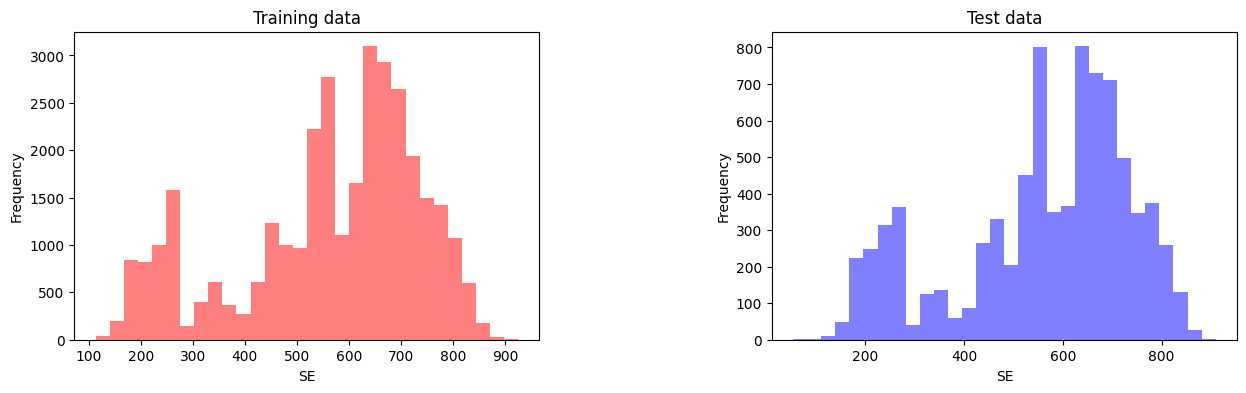

In [2]:
CSI_RSRP_COLUMNS = ['PCell1 -Beam CSI-RSRP','PCell2 -Beam CSI-RSRP','PCell3 -Beam CSI-RSRP',
                    'PCell4 -Beam CSI-RSRP','PCell5 -Beam CSI-RSRP','PCell6 -Beam CSI-RSRP','PCell7 -Beam CSI-RSRP','PCell8 -Beam CSI-RSRP']
CSI_RSRQ_COLUMNS = ['PCell1 -Beam CSI-RSRQ','PCell2 -Beam CSI-RSRQ','PCell3 -Beam CSI-RSRQ',
                    'PCell4 -Beam CSI-RSRQ','PCell5 -Beam CSI-RSRQ','PCell6 -Beam CSI-RSRQ','PCell7 -Beam CSI-RSRQ','PCell8 -Beam CSI-RSRQ']
CSI_SINR_COLUMNS = ['PCell1 -Beam CSI-SINR','PCell2 -Beam CSI-SINR','PCell3 -Beam CSI-SINR',
                    'PCell4 -Beam CSI-SINR','PCell5 -Beam CSI-SINR','PCell6 -Beam CSI-SINR','PCell7 -Beam CSI-SINR','PCell8 -Beam CSI-SINR']
CSI_INDEX_COLUMNS = ['PCell1 -Beam CSI-Index','PCell2 -Beam CSI-Index','PCell3 -Beam CSI-Index',
                    'PCell4 -Beam CSI-Index','PCell5 -Beam CSI-Index','PCell6 -Beam CSI-Index','PCell7 -Beam CSI-Index','PCell8 -Beam CSI-Index']
SS_SINR_COLUMNS = ['SSB Index0 SINR','SSB Index1 SINR','SSB Index2 SINR','SSB Index3 SINR','SSB Index4 SINR','SSB Index5 SINR','SSB Index6 SINR']
SS_RSRP_COLUMNS = ['SSB Index0 RSRP','SSB Index1 RSRP','SSB Index2 RSRP','SSB Index3 RSRP','SSB Index4 RSRP','SSB Index5 RSRP','SSB Index6 RSRP']
CSI_SERVING_COL = ['PCell1 -Beam Serving Beam','PCell2 -Beam Serving Beam','PCell3 -Beam Serving Beam','PCell4 -Beam Serving Beam','PCell5 -Beam Serving Beam',
                   'PCell6 -Beam Serving Beam','PCell7 -Beam Serving Beam','PCell8 -Beam Serving Beam']
CSI_RSRP_IDX_COLUNMS = ['CSI-RSRP-Index0', 'CSI-RSRP-Index1', 'CSI-RSRP-Index2', 'CSI-RSRP-Index3', 'CSI-RSRP-Index4', 'CSI-RSRP-Index5','CSI-RSRP-Index6', 'CSI-RSRP-Index7',
                        'CSI-RSRP-Index8', 'CSI-RSRP-Index9', 'CSI-RSRP-Index10', 'CSI-RSRP-Index11', 'CSI-RSRP-Index12','CSI-RSRP-Index13', 'CSI-RSRP-Index14', 'CSI-RSRP-Index15',
                        'CSI-RSRP-Index16', 'CSI-RSRP-Index17', 'CSI-RSRP-Index18', 'CSI-RSRP-Index19','CSI-RSRP-Index20', 'CSI-RSRP-Index21', 'CSI-RSRP-Index22', 'CSI-RSRP-Index23',
                        'CSI-RSRP-Index24', 'CSI-RSRP-Index25', 'CSI-RSRP-Index26', 'CSI-RSRP-Index27', 'CSI-RSRP-Index28', 'CSI-RSRP-Index29', 'CSI-RSRP-Index30', 'CSI-RSRP-Index31']
CSI_SINR_IDX_COLUNMS = ['CSI-SINR-Index0', 'CSI-SINR-Index1', 'CSI-SINR-Index2', 'CSI-SINR-Index3', 'CSI-SINR-Index4', 'CSI-SINR-Index5','CSI-SINR-Index6', 'CSI-SINR-Index7',
                        'CSI-SINR-Index8', 'CSI-SINR-Index9', 'CSI-SINR-Index10', 'CSI-SINR-Index11', 'CSI-SINR-Index12','CSI-SINR-Index13', 'CSI-SINR-Index14', 'CSI-SINR-Index15',
                        'CSI-SINR-Index16', 'CSI-SINR-Index17', 'CSI-SINR-Index18', 'CSI-SINR-Index19','CSI-SINR-Index20', 'CSI-SINR-Index21', 'CSI-SINR-Index22', 'CSI-SINR-Index23',
                        'CSI-SINR-Index24', 'CSI-SINR-Index25', 'CSI-SINR-Index26', 'CSI-SINR-Index27', 'CSI-SINR-Index28', 'CSI-SINR-Index29', 'CSI-SINR-Index30', 'CSI-SINR-Index31']
PERFORMANCE_COLUMNS = ['NR MAC Throughput DL','NR PRB Num DL/s','NR PRB Num DL/slot','NR RI','NR Avg Rank DL/s',
                       'NR DL Total NACK/s','NR DL Total ACK/s','NR PDSCH Initial BLER','NR PDSCH BLER','NR DL Avg MCS'] 
LOC_COLUMNS = ['Longitude','Latitude']
ALL_COLUMNS = CSI_RSRP_COLUMNS+CSI_RSRQ_COLUMNS+CSI_SINR_COLUMNS+CSI_INDEX_COLUMNS+SS_SINR_COLUMNS+SS_RSRP_COLUMNS+PERFORMANCE_COLUMNS
# 归一化参数
RSRP_MAX = -40
RSRP_MIN = -125
RSRQ_MAX = -4
RSRQ_MIN = -30
SE_MAX = 4000
RI_MAX = 4
MCS_MAX = 27
SINR_MAX = 50
SINR_MIN = -20
RI_COLUMN = ['NR Avg Rank DL/s']
MCS_COLUMN = ['NR DL Avg MCS']
BLER_COLUMN = ['NR PDSCH BLER']
SEVING_IDX = ['Serving idx']

SE_COLUMNS = ['NR MAC Throughput DL','NR PRB Num DL/s']
train_features = CSI_RSRP_IDX_COLUNMS+SS_RSRP_COLUMNS

with open('dt_cuhk/0415/data_set/data_834_linear_by_idx.pkl','rb') as f:
    data_set_834_415 = pickle.load(f)
with open('dt_cuhk/0412/data_set/data_900_linear_by_idx.pkl','rb') as f:
    data_set_900_412 = pickle.load(f)
with open('dt_cuhk/0418/data_set/data_834_linear_by_idx.pkl','rb') as f:
    data_set_834_418 = pickle.load(f)
with open('dt_cuhk/0420/data_set/data_834_linear_by_idx.pkl','rb') as f:
    data_set_834_420 = pickle.load(f)
with open('dt_cuhk/0426/data_set/data_834_linear_by_idx.pkl','rb') as f:
    data_set_834_426 = pickle.load(f)
    

# with open('dataset_514/0415/data_834_linear_by_idx_loc.pkl','rb') as f:
#     data_set_834_415 = pickle.load(f)
# with open('dataset_514/0418/data_834_linear_by_idx_loc.pkl','rb') as f:
#     data_set_834_418 = pickle.load(f)
# with open('dataset_514/0420/data_834_linear_by_idx_loc.pkl','rb') as f:
#     data_set_834_420 = pickle.load(f)
# with open('dataset_514/0426/data_834_linear_by_idx_loc.pkl','rb') as f:
#     data_set_834_426 = pickle.load(f)
    
data_set_834 = pd.concat((data_set_834_415,data_set_834_418,data_set_834_420,data_set_834_426))


# LANGITUDE = [114,115]
# LATITUDE = [22,23]
# data_set_834[LOC_COLUMNS[0]] = (data_set_834[LOC_COLUMNS[0]] - LANGITUDE[0])/(LANGITUDE[1]-LANGITUDE[0])
# data_set_834[LOC_COLUMNS[1]] = (data_set_834[LOC_COLUMNS[1]] - LATITUDE[0])/(LATITUDE[1]-LATITUDE[0])

# with open('dataset_503/data_834_train_test.pkl','rb') as f:
#     train,test = pickle.load(f)
    
train,test = train_test_split(data_set_834,test_size=0.2,shuffle=True,random_state=1)

train_x = train[train_features]
train_y = train['SE']

test_x = test[train_features]
test_y = test['SE']


# 创建三个子图
fig, axs = plt.subplots(1, 2, figsize=(15, 4))

# 绘制第一个子图
axs[0].hist(train['NR MAC Throughput DL'], bins=30, alpha=0.5, color='r')
axs[0].set_xlabel('SE')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Training data')


# 绘制第二个子图
axs[1].hist(test['NR MAC Throughput DL'], bins=30, alpha=0.5, color='b')
axs[1].set_xlabel('SE')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Test data')

# 调整子图之间的距离
plt.subplots_adjust(wspace=0.5)

# 显示图像
plt.show()


train_x = train_x[train_features].to_numpy()
test_x = test_x[train_features].to_numpy()
train_y = train_y.to_numpy()
test_y = test_y.to_numpy()

data_dim = 1
cond_dim = len(train_features)
X_tensor = torch.FloatTensor(train_y).reshape(-1,1)
r_tensor = torch.FloatTensor(train_x[:,:cond_dim])

## Reflected Diffusion

In [3]:
def index_iterator(data_len, batch_size, shuffle=True):
    if shuffle:
        indices = np.random.permutation(data_len)
    else:
        indices = np.arange(data_len)
    for i in range(0, data_len, batch_size):
        yield indices[i:i+batch_size]

class GaussianFourierProjection(nn.Module):
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        # Randomly sample weights during initialization. These weights are fixed 
        # during optimization and are not trainable.
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

class MyBlock(nn.Module):
    def __init__(self, shape, out_c, block_layer):
        super(MyBlock, self).__init__()
        self.w1 = nn.Linear(shape, out_c)
        self.block_layer = block_layer
        for nl in range(2,self.block_layer+1):
            setattr(self,"w_"+str(nl),nn.Linear(out_c,out_c))
        self.activation = lambda x: x * torch.sigmoid(x)


    def forward(self, x):
        out = self.w1(x)
        out = self.activation(out)
        for nl in range(2,self.block_layer+1):
            out = self.activation(getattr(self,"w_"+str(nl))(out))
        return out

class UNet_MLP(nn.Module):
    def __init__(self, input_dim, cond_dim, cond_emb_dim = 128, time_emb_dim=128, scale = 11, block_layer = 2):
        super(UNet_MLP, self).__init__()

        # Sinusoidal embedding
        self.act = lambda x: x * torch.sigmoid(x)
        # Sinusoidal embedding
        self.time_embed = nn.Sequential(GaussianFourierProjection(embed_dim=time_emb_dim),
         nn.Linear(time_emb_dim, time_emb_dim))
        
        self.input_dim = input_dim

        self.cond_embed = MyBlock(cond_dim,cond_emb_dim,block_layer)
        self.cond_embed_dim = cond_emb_dim
        
        # First half
        first_num = 2 ** scale
        self.x_embed = MyBlock(input_dim,first_num,block_layer)
        
        self.te1 = self._make_emb(time_emb_dim, first_num)
        self.ce1 = self._make_emb(cond_emb_dim, first_num)
        self.b1 = MyBlock(first_num, first_num,block_layer)

        

        second_num = first_num // 2
        self.down1 = MyBlock(first_num,second_num,block_layer)
        
        self.te2 = self._make_emb(time_emb_dim, second_num)
        self.ce2 = self._make_emb(cond_emb_dim , second_num)
        self.b2 = MyBlock(second_num,second_num,block_layer)
    
        
        third_num = second_num // 2
        self.down2 = MyBlock(second_num,third_num,block_layer)


        # Bottleneck
        self.te_mid = self._make_emb(time_emb_dim, third_num)
        self.ce_mid = self._make_emb(cond_emb_dim, third_num)
        self.b_mid = MyBlock(third_num, third_num,block_layer)
    

        # Second half
        self.up1 = MyBlock(third_num, second_num,block_layer)

        self.te3 = self._make_emb(time_emb_dim, first_num)
        self.ce3 = self._make_emb(cond_emb_dim, first_num)
        self.b3 = MyBlock(first_num, second_num,block_layer)

        self.up2 = MyBlock(second_num, first_num,block_layer)
        self.te4 = self._make_emb(time_emb_dim, first_num * 2)
        self.ce4 = self._make_emb(cond_emb_dim, first_num * 2)
        self.b4 = MyBlock(first_num * 2, first_num,block_layer)
        

        self.final = nn.Linear(first_num, input_dim)

    def forward(self, x0, ti, xc_inp = None):
        t = self.act(self.time_embed(ti))
        x = self.x_embed(x0)
        if xc_inp is None:
            xc = torch.zeros(x.shape[0],self.cond_embed_dim).to(x.device) - 1
        else:
            xc = self.cond_embed(xc_inp)
        
        out1 = self.b1(x + self.te1(t) + self.ce1(xc))   # (N, first_num) 
        out2 = self.b2(self.down1(out1) + self.te2(t) + self.ce2(xc))    # (N, second_num)
        out_mid = self.b_mid(self.down2(out2)+ self.te_mid(t) + self.ce_mid(xc))   # (N, third_num)
        
        out3 = torch.cat((out2, self.up1(out_mid)), dim=1)  # (N, first_num)
        out4 = self.b3(out3+ self.te3(t)+ self.ce3(xc))    # (N, second)

        out5 = torch.cat((out1, self.up2(out4)), dim=1)  # (N, first_num * 2)
        out6 = self.b4(out5+ self.te4(t)+ self.ce4(xc))    # (N, first_num)

        out = self.final(out6) # (N, out)

        return out

    def _make_emb(self, dim_in, dim_out):
        return nn.Linear(dim_in, dim_out)

# define the denoising loss

In [4]:
def bounded_denoising_loss(net, batch_data, batch_cond, eps = 1e-5):
    batch_len = len(batch_data)
    noisy_levels = (torch.rand(batch_len).cuda()) * (1 - 2 * eps) + eps # 0.001 ~ 1
    noise = torch.randn(batch_data.shape).cuda()
    noisy_data = batch_data * torch.sqrt(1 - noisy_levels.reshape(-1,1)) + torch.sqrt(noisy_levels.reshape(-1,1)) * noise
    # noisy_data /= torch.norm(noisy_data,dim=1).reshape(-1,1) # the bounded set is the unit sphere
    noisy_data = torch.clip(noisy_data,0.0,1.0)
    predicted_noise = net(noisy_data, noisy_levels, batch_cond)
    loss  = torch.mean(torch.sum((predicted_noise - noise)**2, dim = 1)) 
    return loss

# Generation function

In [5]:
def ddim_sampling(model, batch_cond, total_steps = 1000, eps = 1e-5, eta = 1.):
    # generation
    now_coeff = 1 - eps
    interp = now_coeff / total_steps
    sample_points = torch.randn(len(batch_cond),data_dim).cuda()

    for _ in range(total_steps-1):
        nl = eta * np.sqrt(now_coeff - interp) 
        with torch.no_grad():
            direction = model(sample_points, torch.zeros(len(batch_cond)).cuda() + now_coeff, batch_cond)
        sample_points = np.sqrt(1-now_coeff+interp) * (sample_points - np.sqrt(now_coeff) * direction) / np.sqrt(1-now_coeff) + np.sqrt(max([now_coeff - interp - nl**2, 0])) * direction + nl * torch.randn(len(batch_cond),data_dim).cuda()
        now_coeff -= interp

    return sample_points.cpu().numpy()

def bounded_ddim_sampling(model, batch_cond, total_steps = 1000, eps = 1e-5, eta = 1.):
    # generation
    now_coeff = 1 - eps
    interp = now_coeff / total_steps
    sample_points = torch.randn(len(batch_cond),data_dim).cuda()

    for _ in range(total_steps-1):
        nl = eta * np.sqrt(now_coeff - interp) 
        with torch.no_grad():
            direction = model(sample_points, torch.zeros(len(batch_cond)).cuda() + now_coeff, batch_cond)
        sample_points = np.sqrt(1-now_coeff+interp) * (sample_points - np.sqrt(now_coeff) * direction) / np.sqrt(1-now_coeff) + np.sqrt(max([now_coeff - interp - nl**2, 0])) * direction + nl * torch.randn(len(batch_cond),data_dim).cuda()
        # sample_points /= torch.norm(sample_points,dim=1).reshape(-1,1) # projection to constraint set
        sample_points = torch.clip(sample_points,0.0,1.0) # projection to constraint set
        now_coeff -= interp

    return sample_points.cpu().numpy()    

In [6]:
model = UNet_MLP(data_dim, 39).cuda()
EMA_model = UNet_MLP(data_dim, 39).cuda()
EMA_model.load_state_dict(deepcopy(model.state_dict()))
best_loss = np.inf

In [11]:
EPOCH = 4000

lr=1e-4
batch_size = 128
patience = 1000
train_data = X_tensor.cuda()
cond_data = r_tensor.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
no_improvement_count = 0
progress = tqdm(range(EPOCH))
for epoch in progress:
    avg_loss = 0
    totals = 0
    for batch_idx in index_iterator(len(train_data), batch_size):
        optimizer.zero_grad()
        loss  = bounded_denoising_loss(model, train_data[batch_idx],cond_data[batch_idx])
        loss.backward()
        optimizer.step()
        totals += len(batch_idx)
        avg_loss += loss.item() * len(batch_idx)
    
    for p, ema_p in zip(model.parameters(), EMA_model.parameters()):
        ema_p.data.mul_(0.99).add_(0.01, p.data)

    progress.set_postfix({"avg_loss":avg_loss/totals,"last_loss":loss.item()})

    # if (epoch + 1) % 2000 == 0:
    #     ema_sample_points = np.concatenate([ddim_sampling(EMA_model,cond_data) for _ in tqdm(range(10))],axis=1).mean(axis=1)
    #     sample_points = np.concatenate([ddim_sampling(model,cond_data) for _ in tqdm(range(10))],axis=1).mean(axis=1)
    #     ema_sample_points_eta0 = np.concatenate([bounded_ddim_sampling(EMA_model,cond_data) for _ in tqdm(range(10))],axis=1).mean(axis=1)
    #     sample_points_eta0 = np.concatenate([bounded_ddim_sampling(model,cond_data) for _ in tqdm(range(10))],axis=1).mean(axis=1)
    #     plt.figure(figsize=(14,5))
    #     plt.plot(ema_sample_points[:60]*SE_MAX,label="ema_sample_points")
    #     plt.plot(sample_points[:60]*SE_MAX,label="sample_points")
    #     plt.plot(ema_sample_points_eta0[:60]*SE_MAX,label="ema_sample_points_eta0")
    #     plt.plot(sample_points_eta0[:60]*SE_MAX,label="sample_points_eta0")
    #     plt.plot(X_tensor[:60]*SE_MAX,label="ground truth")
    #     plt.legend()
    #     plt.show()
    #     print("saved at epoch {}".format(epoch))
        
    if epoch % 200 == 0:     
        torch.save(model.state_dict(), "./reflected_model/model_diff.pkl")
        torch.save(EMA_model.state_dict(), "./reflected_model/ema_model_diff.pkl")
        print("save model")
        
    # check if current loss is better than best loss
    if avg_loss/totals < best_loss:
        best_loss = avg_loss/totals
        no_improvement_count = 0
        best_model_state_dict = model.state_dict()
        best_ema_model_state_dict = EMA_model.state_dict()
    else:
        no_improvement_count += 1
    if no_improvement_count >= patience:
        print("Early stopping at epoch", epoch)
        break
        
# save the best model to file
if best_model_state_dict is not None:
    torch.save(best_model_state_dict, "./reflected_model/best_model_diff_834.pkl")
    torch.save(best_ema_model_state_dict, "./reflected_model/best_ema_model_diff_834.pkl")
    print("save best model with loss: ", best_loss)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 1/4000 [00:05<5:42:25,  5.14s/it, avg_loss=0.239, last_loss=0.157]

save model


  5%|▌         | 201/4000 [14:47<4:51:40,  4.61s/it, avg_loss=0.13, last_loss=0.0782] 

save model


 10%|█         | 401/4000 [29:30<4:35:56,  4.60s/it, avg_loss=0.129, last_loss=0.111] 

save model


 15%|█▌        | 601/4000 [44:15<4:20:06,  4.59s/it, avg_loss=0.132, last_loss=0.172] 

save model


 20%|██        | 801/4000 [58:57<4:05:41,  4.61s/it, avg_loss=0.127, last_loss=0.0701]

save model


 25%|██▌       | 1001/4000 [1:13:40<3:48:53,  4.58s/it, avg_loss=0.126, last_loss=0.0894]

save model


 30%|███       | 1201/4000 [1:28:22<3:34:11,  4.59s/it, avg_loss=0.128, last_loss=0.0931]

save model


 35%|███▌      | 1401/4000 [1:43:05<3:20:30,  4.63s/it, avg_loss=0.12, last_loss=0.151]  

save model


 40%|████      | 1601/4000 [1:57:49<3:03:12,  4.58s/it, avg_loss=0.125, last_loss=0.124]   

save model


 45%|████▌     | 1801/4000 [2:12:31<2:47:51,  4.58s/it, avg_loss=0.129, last_loss=0.0816]

save model


 50%|█████     | 2001/4000 [2:27:17<2:32:35,  4.58s/it, avg_loss=0.125, last_loss=0.172] 

save model


 55%|█████▌    | 2201/4000 [2:41:57<2:17:11,  4.58s/it, avg_loss=0.125, last_loss=0.0792]

save model


 60%|██████    | 2400/4000 [2:56:41<1:57:47,  4.42s/it, avg_loss=0.127, last_loss=0.1]     

save model
Early stopping at epoch 2400


save best model with loss:  0.11965835187847453


In [8]:
test_tensor = torch.FloatTensor(test_x[:,:cond_dim]).cuda()
test_y_tensor = torch.FloatTensor(test_y)

In [9]:
model.load_state_dict(torch.load("./reflected_model/best_model_diff_834.pkl"))
EMA_model.load_state_dict(torch.load("./reflected_model/best_ema_model_diff_834.pkl"))
sample_size = 100 # the number of sample to draw from diffusion for each input
sampled_y_1 = np.concatenate([bounded_ddim_sampling(model,test_tensor) for _ in tqdm(range(sample_size))],axis=1)

100%|██████████| 100/100 [1:17:52<00:00, 46.72s/it]


In [10]:
sampled_y_2 = np.concatenate([bounded_ddim_sampling(EMA_model,test_tensor.cuda()) for _ in tqdm(range(sample_size))],axis=1)


100%|██████████| 100/100 [1:14:37<00:00, 44.78s/it]


In [14]:
sampled_y = sampled_y_2
# sampled_y = sampled_y_1
used_sample_size = sample_size
sample_y_mean = sampled_y[:,:used_sample_size].mean(axis=1)

In [15]:

print('mse:')
print("diffusion average min error over 10 samples:", np.mean(((sampled_y[:,:used_sample_size]-test_y.reshape(-1,1))**2).min(axis=1)))
print("diffusion mean:", np.mean((sample_y_mean-test_y)**2))
# print("mlp:", np.mean((mlp_est_y-test_y)**2))
# print("svr :", np.mean((svr_y-test_y)**2))
print('max error:')
# print("diffusion average min error over 10 samples:", np.max(((sampled_y[:,:10].numpy()-test_y.reshape(-1,1))**2).min(axis=1)))
print("diffusion mean:", np.max((sample_y_mean-test_y)**2),)
# print("mlp:",np.max((mlp_est_y-test_y)**2))
# print("svr:", np.max((svr_y-test_y)**2))
print('mape:')
print("diffusion average min error over 10 samples:", np.mean((np.abs((sampled_y[:,:used_sample_size]-test_y.reshape(-1,1))/test_y.reshape(-1,1))).min(axis=1)))
print("diffusion mean:",np.mean(np.abs((sample_y_mean-test_y)/test_y)))
# print("mlp:",np.mean(np.abs((mlp_est_y-test_y)/test_y)))
# print("svr:",np.mean(np.abs((svr_y-test_y)/test_y)))
print('sdape:')
print("diffusion average min error over 10 samples:", np.std((np.abs((sampled_y[:,:used_sample_size]-test_y.reshape(-1,1))/test_y.reshape(-1,1))).min(axis=1)))
print("diffusion mean:",np.std(np.abs((sample_y_mean-test_y)/test_y)))
# print("mlp:",np.std(np.abs((mlp_est_y-test_y)/test_y)))
# print("svr:",np.std(np.abs((svr_y-test_y)/test_y)))

mse:
diffusion average min error over 10 samples: 2.1646919607654097e-05
diffusion mean: 0.0012183548225403959
max error:
diffusion mean: 0.05717932664543841
mape:
diffusion average min error over 10 samples: 0.003950641300863335
diffusion mean: 0.06884877142256132
sdape:
diffusion average min error over 10 samples: 0.04320153501841021
diffusion mean: 0.10117584625902118


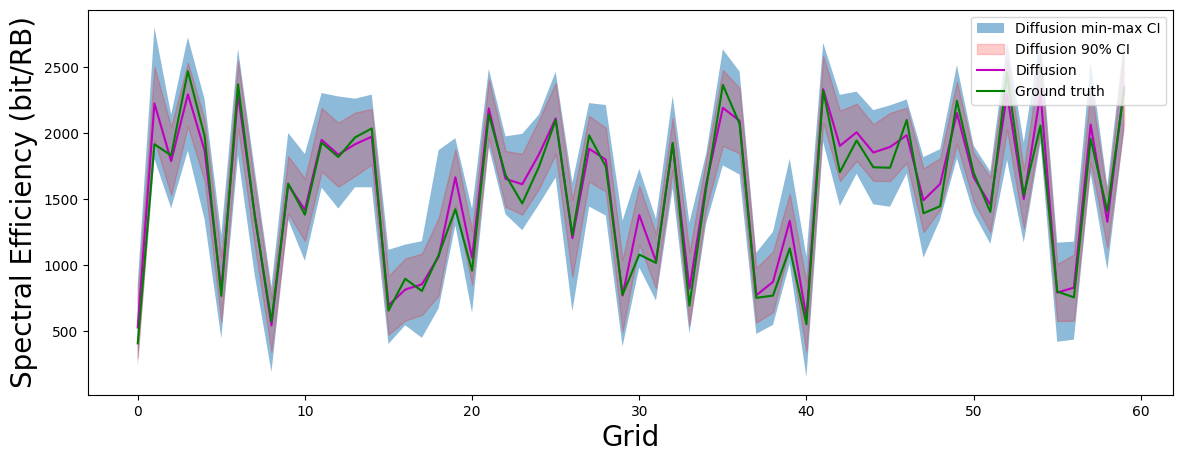

coverage of 90% CI 92.26512690965957
coverage of 95% CI 95.65740406592084
coverage of 99% CI 98.60459521231806
coverage of min-max interval 98.25574401539757


In [16]:
start_id = 50
domain=60
# domain_x = np.argsort(np.abs((sample_y_mean-test_y)/test_y))[start_id:start_id+domain]
domain_x = np.arange(60)

sample_y_std = sampled_y[:,:used_sample_size].std(axis=1)


CI90 = 1.645
CI95 = 1.96
CI99 = 2.576

plt.figure(figsize=(14,5),)

plt.fill_between(np.arange(domain),(sampled_y.min(axis=1)[domain_x])*SE_MAX,(sampled_y.max(axis=1)[domain_x])*SE_MAX,alpha=0.5,label="Diffusion min-max CI")
plt.fill_between(np.arange(domain),(sample_y_mean[domain_x]-CI90*sample_y_std[domain_x])*SE_MAX,(sample_y_mean[domain_x]+CI90*sample_y_std[domain_x])*SE_MAX,alpha=0.2,label="Diffusion 90% CI",color='r')
plt.plot(sample_y_mean[domain_x]*SE_MAX,label="Diffusion",color = 'm')
# plt.plot(mlp_est_y[domain_x]*SE_MAX,label="SENet",color = 'y')
plt.plot(test_y[domain_x]*SE_MAX,label="Ground truth",color = 'g')
plt.xlabel('Grid',fontsize=20)
plt.ylabel('Spectral Efficiency (bit/RB)',fontsize=20)
plt.legend(loc='upper right',fontsize=10)
# plt.title("99% CI",fontsize=20)
plt.show()

print("coverage of 90% CI", np.mean((test_y>=(sample_y_mean-CI90*sample_y_std)) & (test_y<=(sample_y_mean+CI90*sample_y_std))) * 100)
print("coverage of 95% CI", np.mean((test_y>=(sample_y_mean-CI95*sample_y_std)) & (test_y<=(sample_y_mean+CI95*sample_y_std))) * 100)
print("coverage of 99% CI", np.mean((test_y>=(sample_y_mean-CI99*sample_y_std)) & (test_y<=(sample_y_mean+CI99*sample_y_std))) * 100)
print("coverage of min-max interval", np.mean((test_y>=sampled_y.min(axis=1)) & (test_y<=sampled_y.max(axis=1))) * 100)

# plt.title("min-max CI",fontsize=20)
plt.show()